In [29]:

from weight_uncertainty.priors import ScaleMixturePrior
from weight_uncertainty.elbo import build_elbo
from weight_uncertainty.training import build_elbo_train_loop
from weight_uncertainty.variational import MeanFieldLinearLayer, sample_predictive
from weight_uncertainty.bnn import MeanFieldNN
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import optax

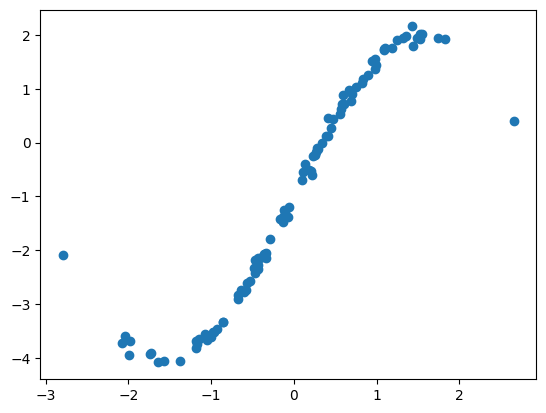

In [39]:
import numpy as np

xs = np.random.normal(size=(100,1)) 
noise = np.random.normal(scale=0.1, size=(100,1))
ys = np.sin(xs) * 3 - 1 + noise

plt.scatter(xs, ys);

In [46]:
prior_fn = ScaleMixturePrior(pi=0.5, var1=0.99, var2=0.01)
model = MeanFieldNN([5, 5, 5, 1], logprior=prior_fn)

key = PRNGKey(123)
key, init_key1, init_key2 = split(key, num=3)
params = model.init(init_key1, {"key":init_key2}, xs[0])

key, subkey = split(key)
state = {"key": subkey}



In [49]:
elbo = build_elbo("regression")

opt = optax.sgd(learning_rate=0.0001)
opt_state = opt.init(params)

train_loop = build_elbo_train_loop(elbo, opt, model, (xs, ys))
epochs = 200
kl_weight = 0.1
for i in range(epochs):
    params, state = train_loop(params, state, opt_state, kl_weight)

ELBO: 8.951122283935547 | MSE: 8.596426010131836 | KL penalty: 0.3546966016292572
ELBO: 7.60842752456665 | MSE: 7.181304931640625 | KL penalty: 0.42712274193763733
ELBO: 5.683421611785889 | MSE: 5.3328857421875 | KL penalty: 0.35053595900535583
ELBO: 10.375113487243652 | MSE: 10.081446647644043 | KL penalty: 0.29366713762283325
ELBO: 6.4080047607421875 | MSE: 6.246725559234619 | KL penalty: 0.16127896308898926
ELBO: 3.0666093826293945 | MSE: 2.697690725326538 | KL penalty: 0.3689187169075012
ELBO: 7.436608791351318 | MSE: 7.2804741859436035 | KL penalty: 0.1561347246170044
ELBO: 3.9185986518859863 | MSE: 3.632333993911743 | KL penalty: 0.2862645387649536
ELBO: 10.71847152709961 | MSE: 10.426440238952637 | KL penalty: 0.29203152656555176
ELBO: 5.937589645385742 | MSE: 5.71198844909668 | KL penalty: 0.22560106217861176
ELBO: 6.414397716522217 | MSE: 6.094822883605957 | KL penalty: 0.3195749521255493
ELBO: 5.740966320037842 | MSE: 5.600400447845459 | KL penalty: 0.14056585729122162
ELBO: 

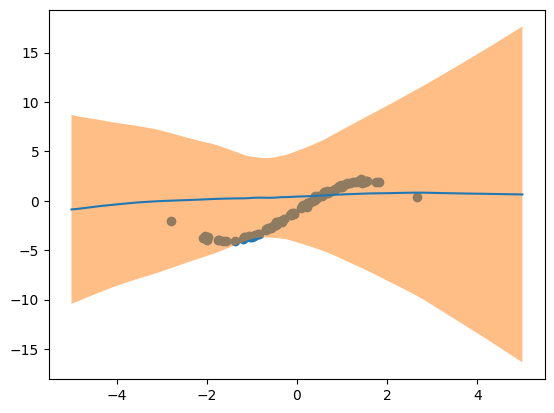

In [50]:
test_xs = np.linspace(-5, 5, 100)[..., np.newaxis]

logits_stacked, _ = sample_predictive(n_samples=15, model=model, init_state=state, params=params, x=test_xs)

logits_mean = logits_stacked.mean(axis=0)
logits_std = logits_stacked.std(axis=0)

plt.scatter(xs, ys);
plt.plot(test_xs, logits_mean);
plt.fill_between(test_xs.squeeze(), (logits_mean-2*logits_std).squeeze(), (logits_mean+2*logits_std).squeeze(), alpha=0.5);